In [1]:
from platform import python_version
print(python_version())

3.11.7


In [2]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from IPython.display import display
from datetime import datetime

In [3]:
# Initialize global variables
total_files = 0
total_files_processed = 0
total_elasped_time = 0
total_files_failed = 0
elapsed_times = []
files_without_elapsed_time = []

folder_path = '/global/cfs/cdirs/dune/users/madan12/DUNE_nesap/pre-post-hackathon/larnd-sim-output-80GB-develop-v2/'
output_file_path = "InputFile_FailedJob.txt"

def process_log_files(directory):
    global total_files, total_files_processed, total_elasped_time, total_files_failed, elapsed_times, files_without_elapsed_time
    file_pattern = re.compile(r'edep-sim input file:\s*(.+)')
    time_pattern = re.compile(r'Elapsed time:\s*([\d.]+)\s*s')

    for filename in os.listdir(directory):
        if filename.endswith(".log") and not filename.endswith("gpu_mem.log"):
        #if filename.endswith(".log"):
            with open(os.path.join(directory, filename), 'r') as file:
                input_file_found = False
                elapsed_time_found = False
                for line in file:
                    file_match = file_pattern.search(line)
                    if file_match:
                        full_path = file_match.group(1)
                        input_file = os.path.basename(full_path)  # Extract file name from the full path
                        # directory_path = os.path.dirname(full_path)
                        # full_path = os.path.join(directory_path, input_file)
                        input_file_found = True
                        total_files_processed += 1

                    time_match = time_pattern.search(line)
                    if time_match:
                        elapsed_time = float(time_match.group(1))  # No conversion to minutes
                        elapsed_times.append(elapsed_time)
                        elapsed_time_found = True
                        total_elasped_time += 1
                        #print(f"{input_file}: Elapsed time: {elapsed_time:.2f} sec")
                
                if not elapsed_time_found and input_file_found:
                    #files_without_elapsed_time.append(input_file)
                    files_without_elapsed_time.append(full_path)

    # Calculate statistics for Job Duration in seconds
    if elapsed_times:
        mean_job_duration = np.mean(elapsed_times)
        median_job_duration = np.median(elapsed_times)
        stdev_job_duration = np.std(elapsed_times)
        min_job_duration = np.min(elapsed_times)
        max_job_duration = np.max(elapsed_times)
    else:
        mean_job_duration = median_job_duration = stdev_job_duration = min_job_duration = max_job_duration = 0.0

    total_files = total_files_processed
    total_files_failed = total_files - total_elasped_time
    print("\n********** Jobs Information **********")
    print(f"Total number of input files processed: {total_files}")
    print(f"Total number of Jobs completed: {total_elasped_time}")
    print(f"Total number of Jobs failed: {total_files_failed}")

    print("\n********** Statistics **********")
    print(f"Mean Job Duration: {mean_job_duration/60:.2f} min")
    print(f"Median Job Duration: {median_job_duration/60:.2f} min")
    print(f"Standard Deviation of Job Duration: {stdev_job_duration/60:.2f} min")
    print(f"Minimum Job Duration: {min_job_duration/60:.2f} min")
    print(f"Maximum Job Duration: {max_job_duration/60:.2f} min")

    # # Print files without elapsed time
    # if files_without_elapsed_time:
    #     #print("\nFiles without 'Elapsed time':")
    #     print("\nFailed Job Input Files:")
    #     for file in files_without_elapsed_time:
    #         print(file)


process_log_files(folder_path)

# Sort the files without elapsed time
files_without_elapsed_time.sort()

# Open the file in write mode ('w')
with open(output_file_path, "w") as output_file:
    # Write sorted files without elapsed time to the file
    if files_without_elapsed_time:
        output_file.write("Files without 'Elapsed time' (sorted):\n")
        for file in files_without_elapsed_time:
            output_file.write(file + "\n")

# Print a message indicating that the output has been written to the file
print(f"Input files that failed the job have been written to '{output_file_path}'")


********** Jobs Information **********
Total number of input files processed: 1000
Total number of Jobs completed: 1000
Total number of Jobs failed: 0

********** Statistics **********
Mean Job Duration: 25.28 min
Median Job Duration: 24.97 min
Standard Deviation of Job Duration: 2.32 min
Minimum Job Duration: 22.26 min
Maximum Job Duration: 69.76 min
Input files that failed the job have been written to 'InputFile_FailedJob.txt'


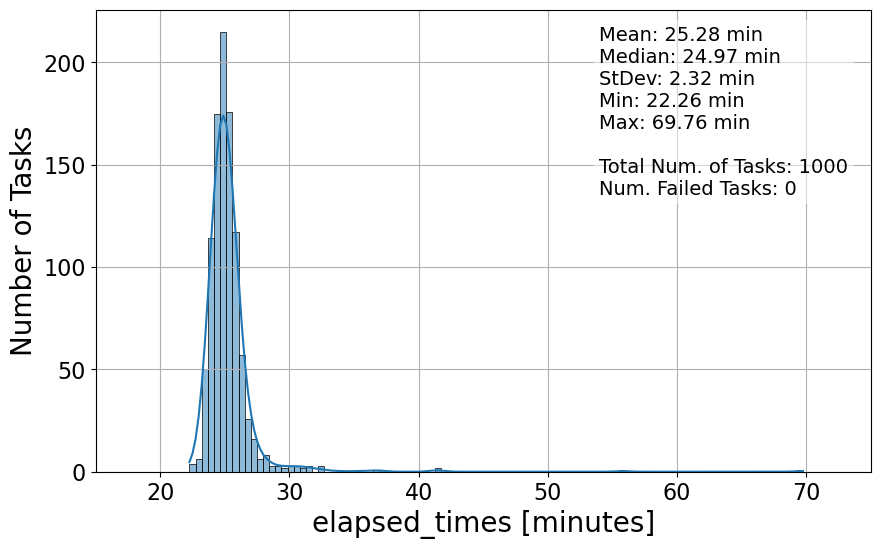

In [4]:

# using 'elapsed_times' from the processed log files
if elapsed_times:
    # Filter job duration values greater than 0 and convert them to minutes
    elapsed_times_min = [duration / 60 for duration in elapsed_times if duration > 0]

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.histplot(elapsed_times_min, bins=100, kde=True)  # Set bins or let seaborn decide

    plt.xlabel('elapsed_times [minutes]', fontsize=20)
    plt.xlim(15, 75)
    plt.ylabel('Number of Tasks', fontsize=20)

    # Set font size for the tick labels on both axes
    plt.tick_params(axis='both', labelsize=16)
    
    # Add statistics text to the plot
    stats_text_job_duration = (
        f"Mean: {np.mean(elapsed_times_min):.2f} min\n"
        f"Median: {np.median(elapsed_times_min):.2f} min\n"
        f"StDev: {np.std(elapsed_times_min):.2f} min\n"
        f"Min: {np.min(elapsed_times_min):.2f} min\n"
        f"Max: {np.max(elapsed_times_min):.2f} min\n"
        f"\n"
        f"Total Num. of Tasks: {total_files}\n"
        f"Num. Failed Tasks: {total_files_failed}"
    )
    plt.text(0.65, 0.6, stats_text_job_duration, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), fontsize=14)
    plt.grid(True)
    # Display and save the plot
    #plot = os.path.join(folder_path, 'DUNE_job_duration.png')
    plot = 'DUNE_elasped_time_develop.png'
    plt.savefig(plot, dpi=200)
    plt.show()

else:
    print("No elapsed_times_min data available to plot.")


In [5]:
# Define the threshold for elapsed time in minutes
elapsed_time_threshold_min = 50

folder_path = '/global/cfs/cdirs/dune/users/madan12/DUNE_nesap/pre-post-hackathon/larnd-sim-output-80GB-develop-v2/'

def check_host_for_long_tasks(log_file_path):
    filename = os.path.basename(log_file_path)  # Extract the filename once at the beginning
    host_name = None
    task_start_time = None
    random_seed = None
    input_file_name = None
    
    with open(log_file_path, 'r') as file:
        for line in file:
            if 'Processing file:' in line:
                parts = line.split(',')
                # Extract the host name, task start time, and random seed
                host_name = parts[5].split(':')[-1].strip()
                task_start_time = parts[3].split('Task Start Time: ')[1].strip()
                random_seed = parts[4].split('Random Seed: ')[1].strip()

            elif 'edep-sim input file:' in line:
                # Extract the input file name
                input_file_path = line.split('edep-sim input file: ')[1].strip()
                input_file_name = os.path.basename(input_file_path)

            elif 'Elapsed time:' in line:
                try:
                    # Convert the elapsed time to float and then to minutes
                    elapsed_time_sec = float(line.split(': ')[1].strip().split(' ')[0])
                    elapsed_time_min = elapsed_time_sec / 60
                    # Check if the elapsed time is greater than the threshold
                    if elapsed_time_min > elapsed_time_threshold_min:
                        # Print if both host name, start time, and elapsed time condition are met
                        if host_name and task_start_time and random_seed and input_file_name:
                            print(f'Host name: {host_name}, Task start time: {task_start_time}, '
                                  f'Random Seed: {random_seed}, Input File: {input_file_name}, '
                                  f'Log File: {filename}')
                                  #f'>= {elapsed_time_threshold_min} minutes in file {filename}')
                            break
                except ValueError:
                    # Handle cases where the conversion to float fails
                    print(f"Error parsing elapsed time in file {log_file_path}: {line}")

def process_all_logs(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.log'):  # Assuming all log files end with .log
            log_file_path = os.path.join(directory, filename)
            check_host_for_long_tasks(log_file_path)
            
process_all_logs(folder_path)

Host name: nid008393, Task start time: 2024-09-13_05:18:04, Random Seed: 7957, Input File: MiniRun5_1E19_RHC.convert2h5.0000997.EDEPSIM.hdf5, Log File: MiniRun5_1E19_RHC.convert2h5.0000997.EDEPSIM_2024-09-13_05:18:04_7957_30368097.log
Host name: nid008428, Task start time: 2024-09-12_23:19:35, Random Seed: 2496, Input File: MiniRun5_1E19_RHC.convert2h5.0000490.EDEPSIM.hdf5, Log File: MiniRun5_1E19_RHC.convert2h5.0000490.EDEPSIM_2024-09-12_23:19:35_2496_30371414.log


In [6]:
# Create a DataFrame based on two different log file and save it as a CSV file
# import os
# import pandas as pd

# Folder path containing the log files
folder_path = '/global/cfs/cdirs/dune/users/madan12/DUNE_nesap/pre-post-hackathon/larnd-sim-output-80GB-develop-v2/'

# Function to parse both the main log file and GPU memory log file
def parse_log_files(log_file_path, gpu_log_file_path):
    data = {
        'file_index': None,
        'input_file': None,
        'output_file': None,
        'log_file': log_file_path,
        'gpu_log_file': gpu_log_file_path,
        'sim_start_time': None,
        'task_start_time': None,
        'elapsed_time(s)': None,
        'task_end_time': None,
        'random_seed': None,
        'job_id': None,
        'host_name': None,
        'gpu_device_id': None,
        'peak_gpu_memory_used': None,
        'gpu_memory_start': None,
        'gpu_memory_end': None,
        'job_completed': False,
        'job_error_msg': None
    }
    
    gpu_memory_usage = []
    
    # Parse the main log file (.log)
    with open(log_file_path, 'r') as file:
        for line in file:
            if 'Processing file:' in line:
                parts = line.split(',')
                data['input_file'] = parts[0].split(': ')[1].strip()
                data['sim_start_time'] = parts[2].split('Sim Start Time: ')[1].strip()
                data['task_start_time'] = parts[3].split('Task Start Time: ')[1].strip()
                data['random_seed'] = parts[4].split(':')[-1].strip()
                data['host_name'] = parts[5].split(':')[-1].strip()
                data['file_index'] = parts[6].split(':')[-1].strip()
                data['job_id'] = parts[7].split(':')[-1].strip()
            elif 'larnd-sim output file:' in line:
                data['output_file'] = line.split(': ')[1].strip()
            elif 'Elapsed time:' in line:
                elapsed_time_str = line.split(': ')[1].strip()
                try:
                    data['elapsed_time(s)'] = float(elapsed_time_str.replace(' s', ''))
                    data['job_completed'] = True
                except ValueError:
                    data['elapsed_time(s)'] = None
            elif 'End Time:' in line:
                data['task_end_time'] = line.split(': ')[1].strip()
            elif 'OutOfMemoryError' in line:
                data['job_error_msg'] = 'OutOfMemoryError'
            elif 'CudaAPIError' in line:
                data['job_error_msg'] = 'CudaAPIError'
            elif 'elapsed_time(s)' not in data and 'task_end_time' not in data:
            #elif 'elapsed_time(s)' not in data and 'task_end_time' not in data and not any(error in line for error in ['OutOfMemoryError', 'CudaAPIError']):
                data['job_error_msg'] = 'incomplete job'

    # Parse the GPU memory log file (.gpu_mem.log)
    if os.path.exists(gpu_log_file_path):
        with open(gpu_log_file_path, 'r') as gpu_file:
            for line in gpu_file:
                if 'MiB' in line and 'memory.used' not in line:
                    parts = line.strip().split(', ')
                    if 'GPU-' in line:
                        gpu_id = parts[-1].strip()
                        memory_used_str = parts[-2].strip().split()[0]
                        try:
                            memory_used = int(memory_used_str)
                            if not data['gpu_device_id']:
                                data['gpu_device_id'] = gpu_id
                            if memory_used != 0:
                                gpu_memory_usage.append(memory_used)
                        except ValueError:
                            continue  # Skip lines where conversion fails
    
    if gpu_memory_usage:
        data['gpu_memory_start'] = gpu_memory_usage[0]
        data['gpu_memory_end'] = gpu_memory_usage[-1]
        data['peak_gpu_memory_used'] = max(gpu_memory_usage)

    return data

# Helper function to get file size
def get_file_size_in_mb(file_path):
    if file_path and os.path.exists(file_path):
        try:
            return os.path.getsize(file_path) / (1024 * 1024)
        except FileNotFoundError:
            return 0
    return 0

def collect_data(folder_path):
    all_data = []

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            #if file.endswith('.log') and not file.endswith('.gpu_mem.log'):
            if file.endswith('.log') and not file.endswith('.gpu_mem.log') and not file.endswith('checkpoint.log'):  
                log_file_path = os.path.join(root, file)
                gpu_log_file_path = log_file_path.replace('.log', '.gpu_mem.log')
                parsed_data = parse_log_files(log_file_path, gpu_log_file_path)
                all_data.append(parsed_data)

    df = pd.DataFrame(all_data)
    df = df.drop_duplicates(subset='log_file', keep='first')
    
    if not df.empty:
        df['input_file_size_mb'] = df['input_file'].apply(get_file_size_in_mb)
        df['output_file_size_mb'] = df['output_file'].apply(get_file_size_in_mb)

        # Handle missing or None file_index values
        df['file_index'] = df['file_index'].fillna(-1).astype(int)
        df.sort_values(by='file_index')
        #df.sort_values(by='file_index', inplace=True)

    return df

# Generate the DataFrame
experiments_df = collect_data(folder_path)

# Display the DataFrame to check its contents
display(experiments_df.head())

# Save the DataFrame to a CSV file
experiments_df.to_csv('DUNE_develop.csv', index=False)

,file_index,input_file,output_file,log_file,gpu_log_file,sim_start_time,task_start_time,elapsed_time(s),task_end_time,random_seed,job_id,host_name,gpu_device_id,peak_gpu_memory_used,gpu_memory_start,gpu_memory_end,job_completed,job_error_msg,input_file_size_mb,output_file_size_mb
0,74,/dvs_ro/cfs/cdirs/dune/www/data/2x2/simulation...,/global/cfs/cdirs/dune/users/madan12/DUNE_nesa...,/global/cfs/cdirs/dune/users/madan12/DUNE_nesa...,/global/cfs/cdirs/dune/users/madan12/DUNE_nesa...,2024-09-10_23:47:44,2024-09-11_01:28:54,1481.94,2024-09-11 01:53:38,788,30368099,nid008268,GPU-721a29f8-5f8f-e123-a18d-9183d3ffce2f,47569,491,47551,True,None,28.841431,1474.287010
1,991,/dvs_ro/cfs/cdirs/dune/www/data/2x2/simulation...,/global/cfs/cdirs/dune/users/madan12/DUNE_nesa...,/global/cfs/cdirs/dune/users/madan12/DUNE_nesa...,/global/cfs/cdirs/dune/users/madan12/DUNE_nesa...,2024-09-13_02:19:54,2024-09-13_02:44:34,1525.68,2024-09-13 03:10:02,5465,30368097,nid008393,GPU-6ba4307b-f441-c89d-fcab-bdeb2e72be1f,41087,429,36109,True,None,25.442673,1413.700005
2,818,/dvs_ro/cfs/cdirs/dune/www/data/2x2/simulation...,/global/cfs/cdirs/dune/users/madan12/DUNE_nesa...,/global/cfs/cdirs/dune/users/madan12/DUNE_nesa...,/global/cfs/cdirs/dune/users/madan12/DUNE_nesa...,2024-09-13_02:19:53,2024-09-13_05:37:45,1512.86,2024-09-13 06:03:01,8388,30368097,nid008385,GPU-74182c1d-9fbb-b2fb-a1c1-341ee818acca,43415,429,43405,True,None,25.683884,1449.356766
3,752,/dvs_ro/cfs/cdirs/dune/www/data/2x2/simulation...,/global/cfs/cdirs/dune/users/madan12/DUNE_nesa...,/global/cfs/cdirs/dune/users/madan12/DUNE_nesa...,/global/cfs/cdirs/dune/users/madan12/DUNE_nesa...,2024-09-12_23:59:50,2024-09-13_00:50:09,1527.73,2024-09-13 01:15:39,2307,30371429,nid008304,GPU-7a3a81a3-f679-b81e-c5e0-3f1b02f69fc6,51075,429,46089,True,None,28.400909,1496.052895
4,594,/dvs_ro/cfs/cdirs/dune/www/data/2x2/simulation...,/global/cfs/cdirs/dune/users/madan12/DUNE_nesa...,/global/cfs/cdirs/dune/users/madan12/DUNE_nesa...,/global/cfs/cdirs/dune/users/madan12/DUNE_nesa...,2024-09-12_23:19:34,2024-09-13_00:57:27,1531.98,2024-09-13 01:23:02,3193,30371414,nid008445,GPU-df5710ad-78b3-1a26-eef9-d45100df1e12,41699,429,36731,True,None,26.852478,1509.705498


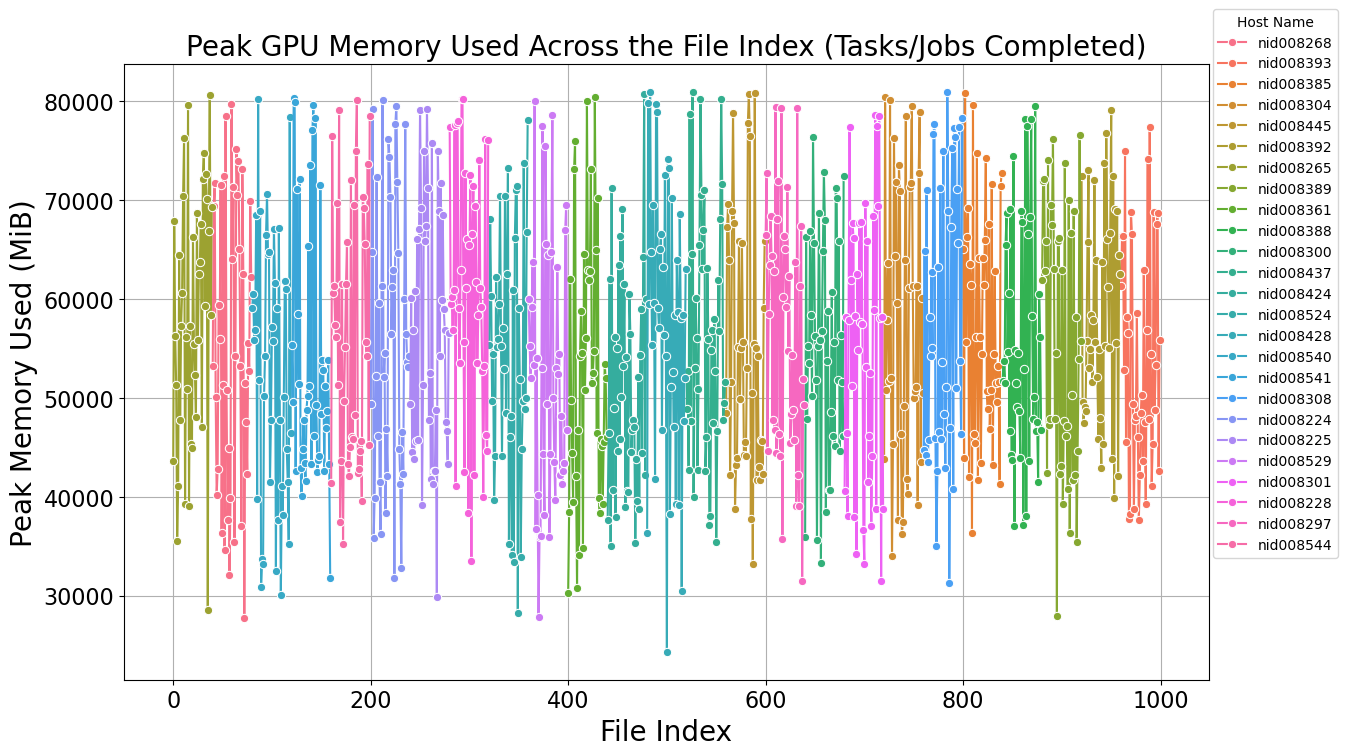

In [7]:
#Peak GPU Memory Used Across the File Index (Tasks/Jobs Completed)

# Filter the DataFrame to include only rows where 'elapsed_time' is not null
filtered_df = experiments_df.dropna(subset=['elapsed_time(s)'])

plt.figure(figsize=(14, 8))  # Set the figure size
sns.lineplot(data=filtered_df, x='file_index', y='peak_gpu_memory_used', hue='host_name', marker='o', legend='full')
plt.title('Peak GPU Memory Used Across the File Index (Tasks/Jobs Completed)', fontsize=20)  # Title of the plot
plt.xlabel('File Index', fontsize=20)  # X-axis label
plt.ylabel('Peak Memory Used (MiB)', fontsize=20)  # Y-axis label
plt.grid(True)  # Enable grid for easier readability
#plt.legend(title='Host Name', loc='upper right')  # Add a legend with a title and move it to a suitable position
plt.legend(title='Host Name', loc='upper right', bbox_to_anchor=(1.125, 1.1))  # Place legend at top outside

# Increase the size of x-ticks and y-ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Display and save the plot
#plot = os.path.join(folder_path, 'DUNE_peak_memory_40GB.png')
plot = 'DUNE_peak_memory_develop.png'
plt.savefig(plot, dpi=200)
plt.show()

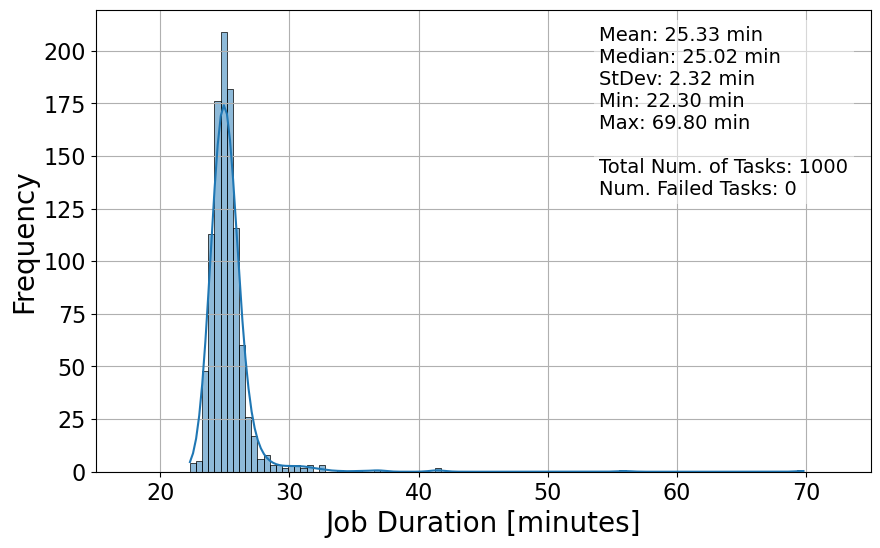

In [8]:
#Distribution of Job Durations (task_end_time - task_start_time)

df=experiments_df
# Ensure task_start_time and task_end_time are in datetime format
df['task_start_time'] = pd.to_datetime(df['task_start_time'], format='%Y-%m-%d_%H:%M:%S')
df['task_end_time'] = pd.to_datetime(df['task_end_time'], format='%Y-%m-%d %H:%M:%S')

# Calculate the job duration only for rows with valid elapsed_time(s)
df['job_duration'] = df.apply(lambda row: row['task_end_time'] - row['task_start_time'] if not pd.isnull(row['elapsed_time(s)']) else pd.NaT, axis=1)

# Convert the job_duration to minutes for easier comparison if needed
df['job_duration_minutes'] = df['job_duration'].dt.total_seconds() / 60

# Calculate statistics
elapsed_times_min = df['job_duration_minutes'].dropna()
mean_duration = np.mean(elapsed_times_min)
median_duration = np.median(elapsed_times_min)
std_duration = np.std(elapsed_times_min)
min_duration = np.min(elapsed_times_min)
max_duration = np.max(elapsed_times_min)
total_files = len(df)
total_files_failed = df['elapsed_time(s)'].isnull().sum()

# Add statistics text to the plot
stats_text_job_duration = (
    f"Mean: {mean_duration:.2f} min\n"
    f"Median: {median_duration:.2f} min\n"
    f"StDev: {std_duration:.2f} min\n"
    f"Min: {min_duration:.2f} min\n"
    f"Max: {max_duration:.2f} min\n"
    f"\n"
    f"Total Num. of Tasks: {total_files}\n"
    f"Num. Failed Tasks: {total_files_failed}"
)

# Plotting the distribution of job durations using Seaborn
plt.figure(figsize=(10, 6))
# Set font size for the tick labels on both axes
plt.tick_params(axis='both', labelsize=16)
sns.histplot(elapsed_times_min, bins=100, kde=True)
#plt.title('Distribution of Job Durations', fontsize=20)
plt.xlabel('Job Duration [minutes]', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xlim(15, 75)
plt.grid(True)

# Adding the statistics box
plt.text(0.65, 0.6, stats_text_job_duration, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), fontsize=14)
plot = 'DUNE_job_duration_develop.png'
plt.savefig(plot, dpi=200)
plt.show()

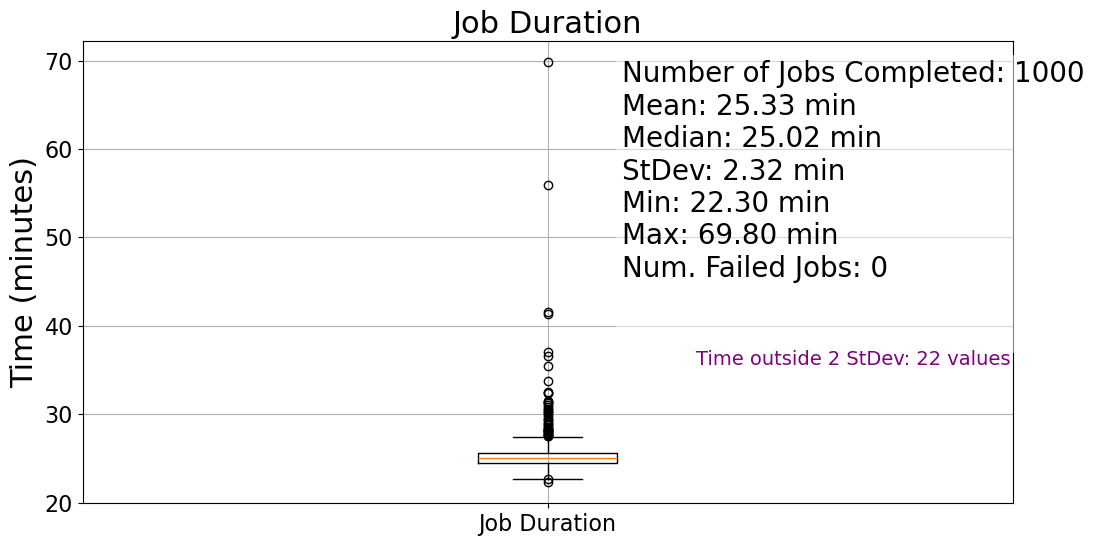

Number of valid elapsed times values: 1000
Number of elapsed time values outside 2 standard deviations: 22


In [9]:
# some fun: DUNE job duration boxplot (minutes)

df=experiments_df
# Ensure task_start_time and task_end_time are in datetime format
df['task_start_time'] = pd.to_datetime(df['task_start_time'], format='%Y-%m-%d_%H:%M:%S')
df['task_end_time'] = pd.to_datetime(df['task_end_time'], format='%Y-%m-%d %H:%M:%S')

# Calculate the job duration only for rows with valid elapsed_time(s)
df['job_duration'] = df.apply(lambda row: row['task_end_time'] - row['task_start_time'] if not pd.isnull(row['elapsed_time(s)']) else pd.NaT, axis=1)

# Convert the job_duration to minutes for easier comparison if needed
df['job_duration_minutes'] = df['job_duration'].dt.total_seconds() / 60

# Filter valid job durations
valid_elapsed_times_minutes = df['job_duration_minutes'].dropna()

# Create a box plot for valid elapsed time values
plt.figure(figsize=(12, 6))
plt.boxplot(valid_elapsed_times_minutes)
plt.title('Job Duration', fontsize=22)
plt.ylabel('Time (minutes)', fontsize=22)
plt.xticks([1], ['Job Duration'], fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)

# Calculate statistics for valid elapsed time values
valid_mean_elapsed_time = np.mean(valid_elapsed_times_minutes)
valid_median_elapsed_time = np.median(valid_elapsed_times_minutes)
valid_stdev_elapsed_time = np.std(valid_elapsed_times_minutes)
valid_min_elapsed_time = np.min(valid_elapsed_times_minutes)
valid_max_elapsed_time = np.max(valid_elapsed_times_minutes)

# Set the number of standard deviations for the threshold
num_stdev = 2  # Change this to your desired number of standard deviations

# Calculate the lower and upper bounds for the threshold
lower_bound = valid_mean_elapsed_time - num_stdev * valid_stdev_elapsed_time
upper_bound = valid_mean_elapsed_time + num_stdev * valid_stdev_elapsed_time

# Count values outside the threshold range
count_outside_threshold = sum(1 for time in valid_elapsed_times_minutes if time < lower_bound or time > upper_bound)

# Add statistics text to the plot
stats_text = (
    f"Number of Jobs Completed: {len(valid_elapsed_times_minutes)}\n"
    f"Mean: {valid_mean_elapsed_time:.2f} min\n"
    f"Median: {valid_median_elapsed_time:.2f} min\n"
    f"StDev: {valid_stdev_elapsed_time:.2f} min\n"
    f"Min: {valid_min_elapsed_time:.2f} min\n"
    f"Max: {valid_max_elapsed_time:.2f} min\n"
    f"Num. Failed Jobs: {df['elapsed_time(s)'].isnull().sum()}\n\n"
)
plt.text(0.58, 0.35, stats_text, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), fontsize=20)

# Adding text inside the plot near the bottom
plt.text(0.66, 0.3, f"Time outside {num_stdev} StDev: {count_outside_threshold} values", color='purple', transform=plt.gca().transAxes, fontsize=14)

# Save the plot
plt.savefig('DUNE_job_duration_boxplot_minutes_develop.png', dpi=200)
plt.show()

# Print the number of valid elapsed times
print("Number of valid elapsed times values:", len(valid_elapsed_times_minutes))

# Print the count of values outside the threshold range
print(f"Number of elapsed time values outside {num_stdev} standard deviations: {count_outside_threshold}")

In [10]:

# Load the CSV file
df = pd.read_csv('DUNE_develop.csv')

# Display basic information and the first few rows of the DataFrame
df.info()
#df.head()

# # # Check for duplicates in the 'log_file' column
# # duplicate_rows = df[df['log_file'].duplicated(keep=False)]
# # # Show the duplicates if any
# # duplicate_rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   file_index            1000 non-null   int64  
 1   input_file            1000 non-null   object 
 2   output_file           1000 non-null   object 
 3   log_file              1000 non-null   object 
 4   gpu_log_file          1000 non-null   object 
 5   sim_start_time        1000 non-null   object 
 6   task_start_time       1000 non-null   object 
 7   elapsed_time(s)       1000 non-null   float64
 8   task_end_time         1000 non-null   object 
 9   random_seed           1000 non-null   int64  
 10  job_id                1000 non-null   int64  
 11  host_name             1000 non-null   object 
 12  gpu_device_id         1000 non-null   object 
 13  peak_gpu_memory_used  1000 non-null   int64  
 14  gpu_memory_start      1000 non-null   int64  
 15  gpu_memory_end        

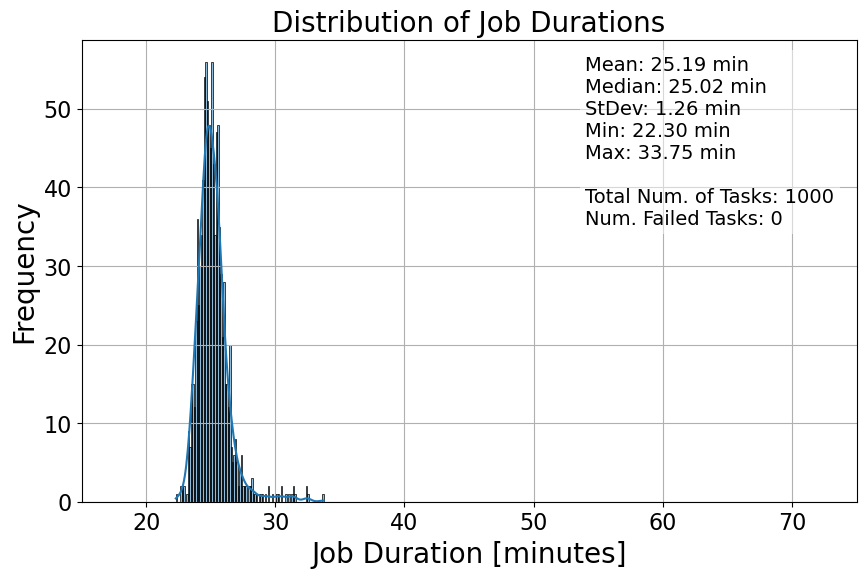

In [11]:

# Make a distribution of job durations plot using CSV file
# Load the CSV file
df = pd.read_csv('DUNE_develop.csv')

# Display basic information and the first few rows of the DataFrame
#df.info()
#print(df.head())

# Ensure task_start_time and task_end_time are in datetime format
df['task_start_time'] = pd.to_datetime(df['task_start_time'], format='%Y-%m-%d_%H:%M:%S')
df['task_end_time'] = pd.to_datetime(df['task_end_time'], format='%Y-%m-%d %H:%M:%S')

# Calculate the job duration only for rows with valid elapsed_time(s)
df['job_duration'] = df.apply(lambda row: row['task_end_time'] - row['task_start_time'] if not pd.isnull(row['elapsed_time(s)']) else pd.NaT, axis=1)

# Convert the job_duration to minutes for easier comparison if needed
df['job_duration_minutes'] = df['job_duration'].dt.total_seconds() / 60

# Calculate statistics
elapsed_times_min = df['job_duration_minutes'].dropna()
# look at only upto 35 min
elapsed_times_min = elapsed_times_min[elapsed_times_min <= 35]
mean_duration = np.mean(elapsed_times_min)
median_duration = np.median(elapsed_times_min)
std_duration = np.std(elapsed_times_min)
min_duration = np.min(elapsed_times_min)
max_duration = np.max(elapsed_times_min)
total_files = len(df)
total_files_failed = df['elapsed_time(s)'].isnull().sum()

# Add statistics text to the plot
stats_text_job_duration = (
    f"Mean: {mean_duration:.2f} min\n"
    f"Median: {median_duration:.2f} min\n"
    f"StDev: {std_duration:.2f} min\n"
    f"Min: {min_duration:.2f} min\n"
    f"Max: {max_duration:.2f} min\n"
    f"\n"
    f"Total Num. of Tasks: {total_files}\n"
    f"Num. Failed Tasks: {total_files_failed}"
)

# Plotting the distribution of job durations using Seaborn
plt.figure(figsize=(10, 6))
# Set font size for the tick labels on both axes
plt.tick_params(axis='both', labelsize=16)
sns.histplot(elapsed_times_min, bins=100, kde=True)
plt.title('Distribution of Job Durations', fontsize=20)
plt.xlabel('Job Duration [minutes]', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xlim(15, 75)
plt.grid(True)

# Adding the statistics box
plt.text(0.65, 0.6, stats_text_job_duration, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), fontsize=14)
plot = 'DUNE_job_duration_develop_2.png'
plt.savefig(plot, dpi=200)
plt.show()
